In [1]:
import torch
from pathlib import Path
import numpy as np
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

In [2]:
plt.style.use('model/lhcb.mplstyle')

In [6]:
from model.models import AltCNN4Layer_D35_sp as Model
from model.collectdata import collect_data, collect_truth
from model.plots import plot_truth_vs_predict
from model.efficiency import efficiency, ValueSet, pv_locations, exact_efficiency
from model.efficiency_res import efficiency_res, ValueSet_res, pv_locations_res, get_resolution, get_nTracks_sorted
from model.training import select_gpu
from model.core import modernize_state

#### Device configuration

In [7]:
# device = select_gpu(2)
device = torch.device("cpu")

#### Load a dataset

In [8]:
valfile_HLT1CPU = Path('/share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5')
valfile = Path('/share/lazy/schreihf/PvFinder/Oct03_20K_val.h5')

In [9]:
validation = collect_data(valfile,
                          batch_size=1,
                          device=device,
                          slice=slice(20000),
                          masking=True)
validation_HLT1CPU = collect_data(valfile_HLT1CPU,
                          batch_size=1,
                          device=device,
                          slice=slice(20000),
                          masking=True)
                                                    

Loading data...
Loaded /share/lazy/schreihf/PvFinder/Oct03_20K_val.h5 in 3.217 s
Constructing 20000 event dataset took 0.09388 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 8.649 s
Constructing 20000 event dataset took 0.1018 s


In [10]:
model = Model().to(device)

#### Load the model weights

Modernizing old style models if needed.

In [11]:
state = torch.load(
    '/share/lazy/schreihf/PvFinder/models/'
    '07Jan19_AltCNN4Layer_D35_sp_300epochs'
    '_240K_lr_3em5_bs256_Alt_Loss_A_5p5/'
    '07Jan19_AltCNN4Layer_D35_sp_300epochs'
    '_240K_lr_3em5_bs256_Alt_Loss_A_5p5_199.pyt'
)

In [12]:
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        # fixing parameters
        param.requires_grad = False 
  ct += 1

ct, child =  0    Sequential(
  (0): Conv1d(1, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.05, inplace=False)
  (3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.05, inplace=False)
  (6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (7): LeakyReLU(negative_slope=0.01)
  (8): Dropout(p=0.05, inplace=False)
  (9): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (10): LeakyReLU(negative_slope=0.01)
  (11): Dropout(p=0.05, inplace=False)
  (12): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (13): Softplus(beta=1, threshold=20)
)


In [13]:
del state['fc1.weight'], state['fc1.bias']

In [14]:
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        # fixing parameters
        param.requires_grad = False 
  ct += 1

ct, child =  0    Sequential(
  (0): Conv1d(1, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.05, inplace=False)
  (3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.05, inplace=False)
  (6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (7): LeakyReLU(negative_slope=0.01)
  (8): Dropout(p=0.05, inplace=False)
  (9): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (10): LeakyReLU(negative_slope=0.01)
  (11): Dropout(p=0.05, inplace=False)
  (12): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (13): Softplus(beta=1, threshold=20)
)


In [15]:
state = modernize_state(model, state)

In [16]:
model.load_state_dict(state)
model.eval()

AltCNN4Layer_D35_sp(
  (features): Sequential(
    (0): Conv1d(1, 25, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.05, inplace=False)
    (3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.05, inplace=False)
    (6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.05, inplace=False)
    (9): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.05, inplace=False)
    (12): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
    (13): Softplus(beta=1, threshold=20)
  )
)

#### Compute the model and move results to Numpy

In [17]:
%%time
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()
with torch.no_grad():
    outputs_HLT1CPU = model(validation_HLT1CPU.dataset.tensors[0]).cpu().numpy()
    labels_HLT1CPU = validation_HLT1CPU.dataset.tensors[1].cpu().numpy()    

CPU times: user 5min 26s, sys: 3min 41s, total: 9min 7s
Wall time: 1min 12s


In [22]:
print(outputs[0])
print(outputs_HLT1CPU[0])


[1.8835339e-27 2.0051556e-28 5.1707084e-29 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
[1.8835339e-27 2.0051556e-28 5.1707084e-29 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


#### Compute the efficencies over the dataset

In [23]:
eff_settings = dict(
    difference = 5., # bins
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3    # bins
)

eff_settings_nodiff = eff_settings.copy()
del eff_settings_nodiff['difference']

In [24]:
%%time
total = ValueSet(0,0,0,0)
i=0
for label, output in zip(labels, outputs):
    total += efficiency(label, output, **eff_settings)
    if i<20:
        print(total)
    i+=1

Found 4 of 4, added 1 (eff 100.00%) (0.5 FP/event)
Found 5 of 5, added 2 (eff 100.00%) (0.667 FP/event)
Found 9 of 10, added 3 (eff 90.00%) (0.75 FP/event)
Found 12 of 14, added 3 (eff 85.71%) (0.6 FP/event)
Found 17 of 19, added 3 (eff 89.47%) (0.5 FP/event)
Found 25 of 27, added 3 (eff 92.59%) (0.429 FP/event)
Found 32 of 34, added 3 (eff 94.12%) (0.375 FP/event)
Found 34 of 36, added 3 (eff 94.44%) (0.333 FP/event)
Found 37 of 39, added 3 (eff 94.87%) (0.3 FP/event)
Found 41 of 44, added 4 (eff 93.18%) (0.364 FP/event)
Found 46 of 49, added 5 (eff 93.88%) (0.417 FP/event)
Found 54 of 58, added 5 (eff 93.10%) (0.385 FP/event)
Found 60 of 64, added 6 (eff 93.75%) (0.429 FP/event)
Found 62 of 66, added 6 (eff 93.94%) (0.4 FP/event)
Found 67 of 71, added 8 (eff 94.37%) (0.5 FP/event)
Found 70 of 74, added 8 (eff 94.59%) (0.471 FP/event)
Found 76 of 80, added 8 (eff 95.00%) (0.444 FP/event)
Found 80 of 84, added 8 (eff 95.24%) (0.421 FP/event)
Found 83 of 88, added 9 (eff 94.32%) (0.45 F

In [25]:
%%time
total_HLT1CPU = ValueSet(0,0,0,0)
i=0
for label_HLT1CPU, output_HLT1CPU in zip(labels_HLT1CPU, outputs_HLT1CPU):
    total_HLT1CPU += efficiency(label_HLT1CPU, output_HLT1CPU, **eff_settings)
    if i<20:
        print(total_HLT1CPU)
    i+=1

Found 4 of 4, added 0 (eff 100.00%) (0.0 FP/event)
Found 11 of 11, added 0 (eff 100.00%) (0.0 FP/event)
Found 16 of 16, added 1 (eff 100.00%) (0.25 FP/event)
Found 19 of 19, added 1 (eff 100.00%) (0.2 FP/event)
Found 23 of 23, added 1 (eff 100.00%) (0.167 FP/event)
Found 27 of 27, added 1 (eff 100.00%) (0.143 FP/event)
Found 31 of 31, added 2 (eff 100.00%) (0.25 FP/event)
Found 34 of 34, added 2 (eff 100.00%) (0.222 FP/event)
Found 38 of 38, added 2 (eff 100.00%) (0.2 FP/event)
Found 44 of 45, added 2 (eff 97.78%) (0.182 FP/event)
Found 49 of 50, added 2 (eff 98.00%) (0.167 FP/event)
Found 56 of 59, added 2 (eff 94.92%) (0.154 FP/event)
Found 61 of 64, added 2 (eff 95.31%) (0.143 FP/event)
Found 67 of 70, added 2 (eff 95.71%) (0.133 FP/event)
Found 69 of 72, added 2 (eff 95.83%) (0.125 FP/event)
Found 76 of 79, added 2 (eff 96.20%) (0.118 FP/event)
Found 79 of 82, added 3 (eff 96.34%) (0.167 FP/event)
Found 88 of 91, added 3 (eff 96.70%) (0.158 FP/event)
Found 95 of 98, added 3 (eff 96

In [26]:
print(total)
#print()
print(total.pretty())

Found 103002 of 109733, added 5021 (eff 93.87%) (0.251 FP/event)
Real PVs in validation set: 109,733
Successes: Either 103,002 or 102,755, depending on how you count.
Missed true PVs: 6,731
False positives: 5,021
Efficiency of detecting real PVs: 93.87%
False positive rate: 0.251


In [27]:
print(total_HLT1CPU)
#print()
print(total_HLT1CPU.pretty())

Found 97912 of 102790, added 5057 (eff 95.25%) (0.253 FP/event)
Real PVs in validation set: 102,790
Successes: Either 97,912 or 97,554, depending on how you count.
Missed true PVs: 4,878
False positives: 5,057
Efficiency of detecting real PVs: 95.25%
False positive rate: 0.253


#### Some examples of the counting algorithm:

In [19]:
for i in range(2):
    result = efficiency(labels[i], outputs[i], **eff_settings)
    print(format(i, '2'), result)

 0 Found 4 of 4, added 1 (eff 100.00%)
 1 Found 1 of 1, added 1 (eff 100.00%)


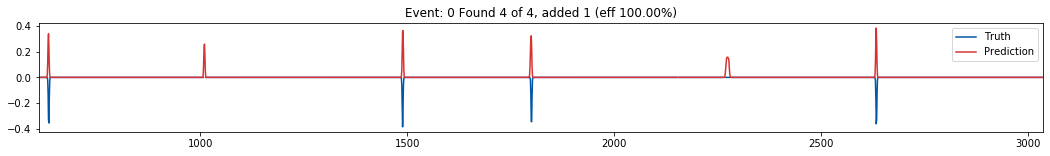

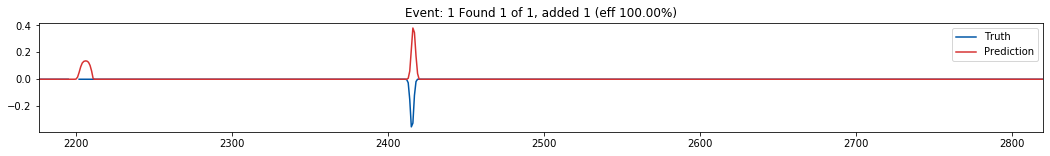

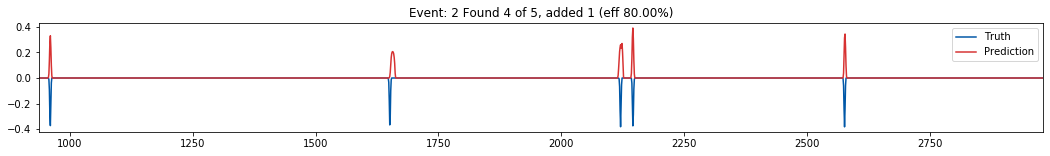

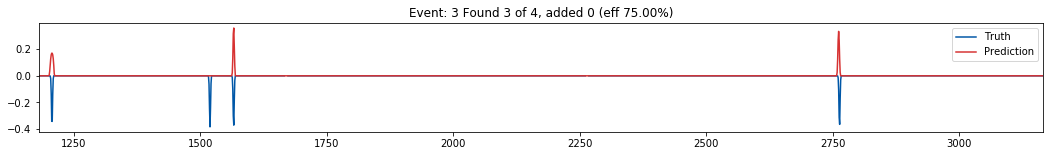

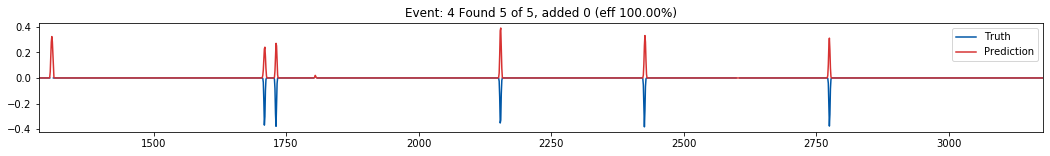

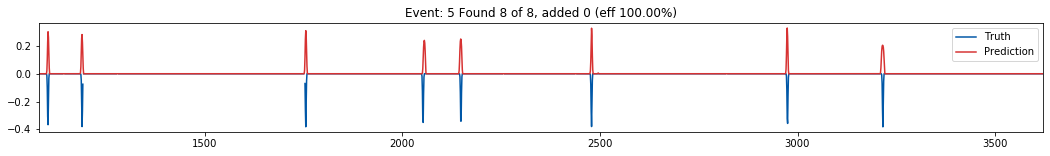

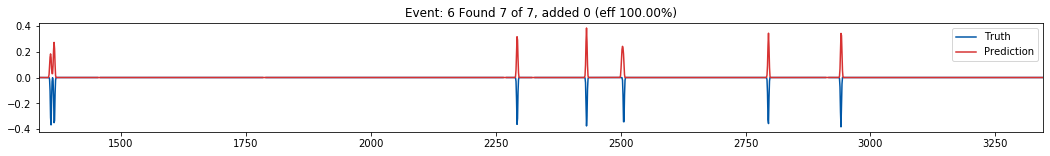

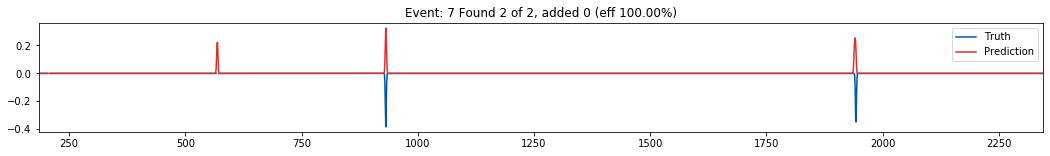

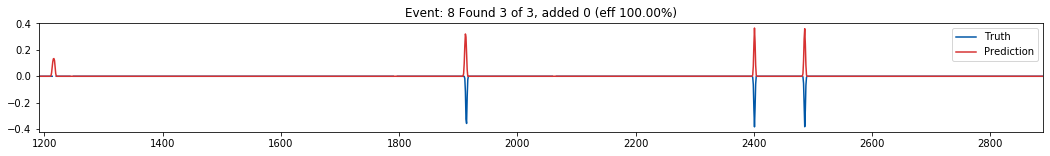

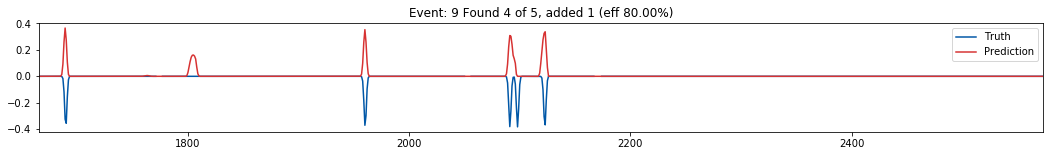

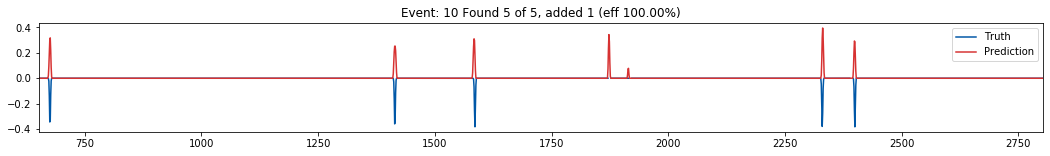

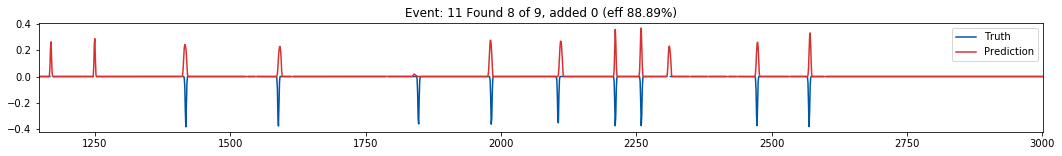

In [20]:
for i in range(12):
    result = efficiency(labels[i], outputs[i], **eff_settings)
    ax = plot_truth_vs_predict(labels[i], outputs[i])
    ax.set_title("Event: "+str(i)+" "+str(result))

#### Calculation using res(nTracks)

In [25]:
global_min_res = 3.0
eff_settings_res = dict(
    nsig_res = 5, # number of sigmas from original res(nTracks)
    min_res = global_min_res, # number of sigmas from original res(nTracks)
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3,    # bins
    debug = 1,    # bins
)
pv_loc_settings = dict(
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3    # bins
)

truth = collect_truth(valfile)
total = ValueSet_res(0,0,0,0)
#total = efficiency_res(labels[0], outputs[0], truth.n[0], truth.z[0], **eff_settings_res)    
#print(total[4])
#total += efficiency_res(labels[1], outputs[1], truth.n[1], truth.z[1], **eff_settings_res) 
#efficiency_res(labels[0], outputs[0], truth.n[0], truth.z[0], **eff_settings_res) 

target_PVs_loc = pv_locations_res(labels[0], **pv_loc_settings)
true_PVs_nTracks = truth.n[0]
true_PVs_z = truth.z[0]
nsig_res = 5.0
min_res = global_min_res
A_res = 926.0
B_res = 0.84
C_res = 10.7
filtered_and_sorted_res = np.empty_like(target_PVs_loc)

print(type(truth.n[0][0]))
print(type(truth_HLT1CPU.n[0][0]))

print(type(truth.z[0][0]))
print(type(truth_HLT1CPU.z[0][0]))


# #filtered_and_sorted_true_PVs_nTracks = np.zeros(len(true_PVs_z[true_PVs_nTracks > 4]), np.float32)
filtered_and_sorted_true_PVs_nTracks = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
filtered_and_sorted_res = (nsig_res*0.01* (A_res / np.power(filtered_and_sorted_true_PVs_nTracks, -1 * B_res) + C_res))
get_resolution(target_PVs_loc, true_PVs_nTracks, true_PVs_z, nsig_res, min_res, 1)
print(get_resolution(pv_locations_res(labels[0], **pv_loc_settings), truth.n[0], truth.z[0], 5.0, global_min_res, 1))
# #get_nTracks_sorted(pv_locations_res(labels[0], **pv_loc_settings), truth.n[0], truth.z[0], 1)

Loaded /share/lazy/schreihf/PvFinder/Oct03_20K_val.h5 in 0.02887 s
<class 'numpy.uint16'>
<class 'numpy.uint16'>
<class 'numpy.float32'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>


TypeError: No matching definition for argument type(s) array(float32, 1d, C), array(uint16, 1d, C), array(float32, 1d, C), float64, float64, int64

In [24]:
truth_HLT1CPU = collect_truth(valfile_HLT1CPU)
total_HLT1CPU = ValueSet_res(0,0,0,0)
target_PVs_loc = pv_locations_res(labels_HLT1CPU[0], **pv_loc_settings)
true_PVs_nTracks = truth_HLT1CPU.n[0]
true_PVs_z = truth_HLT1CPU.z[0]
nsig_res = 5.0
min_res = global_min_res
A_res = 926.0
B_res = 0.84
C_res = 10.7
filtered_and_sorted_res = np.empty_like(target_PVs_loc)


print(type(truth.n[0][0]))
print(type(truth_HLT1CPU.n[0][0]))

print(type(truth.z[0][0]))
print(type(truth_HLT1CPU.z[0][0]))


# #filtered_and_sorted_true_PVs_nTracks = np.zeros(len(true_PVs_z[true_PVs_nTracks > 4]), np.float32)
filtered_and_sorted_true_PVs_nTracks = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
filtered_and_sorted_res = (nsig_res*0.01* (A_res / np.power(filtered_and_sorted_true_PVs_nTracks, -1 * B_res) + C_res))
get_resolution(target_PVs_loc, true_PVs_nTracks, true_PVs_z, nsig_res, min_res, 1)


Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 0.05916 s
<class 'numpy.uint16'>
<class 'numpy.uint16'>
<class 'numpy.float32'>
<class 'numpy.float64'>
Sorted number of tracks (get_resolution):  [11, 62, 14, 12]


array([6.712477 , 3.       , 5.579678 , 6.2770734], dtype=float32)

In [26]:
truth = collect_truth(valfile_HLT1CPU)

global_min_res = 2.0
for i in range(0,10):
    global_nsig_res = 2.0+0.5*i

    eff_settings_res_debug = dict(
        nsig_res = global_nsig_res, # number of sigmas from original res(nTracks)
        min_res = global_min_res, # number of sigmas from original res(nTracks)
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3,    # bins
        debug = 1,    # bins
    )
    eff_settings_res = dict(
        nsig_res = global_nsig_res, # number of sigmas from original res(nTracks)
        min_res = global_min_res, # number of sigmas from original res(nTracks)
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3, # bins
        debug = 0,     # bins
    )
    PV_found_settings_res = dict(
        nsig_res = global_nsig_res, # number of sigmas from original res(nTracks)
        min_res = global_min_res, # number of sigmas from original res(nTracks)
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3,    # bins
        debug = 0    # bins
    )

    big_total = ValueSet_res(0,0,0,0)

    
    res_all = np.ndarray(0,dtype=float)
    for label, output, ns, zs in zip(labels_HLT1CPU, outputs_HLT1CPU, truth.n, truth.z):
        #print(efficiency_res(label, output, ns, zs, **eff_settings_res))
        big_total += efficiency_res(label, output, ns, zs, **eff_settings_res) 
        pv_loc = pv_locations_res(label, **pv_loc_settings)
        res = get_resolution(pv_loc, ns, zs,global_nsig_res,global_min_res,0)
        res_all = np.append(res_all, res)
    #print(total)
    #print(big_total)
    print(f'For {global_nsig_res:.3} sigma resolution (mean = {np.mean(res_all):.3}, std = {np.std(res_all):.3} bins) => eff {big_total.eff_rate:.2%}, FP rate: {big_total.fp_rate:.3}/event')



Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 0.04427 s
For 2.0 sigma resolution (mean = 2.23, std = 0.567 bins) => eff 92.04%, FP rate: 0.4/event
For 2.5 sigma resolution (mean = 2.46, std = 0.863 bins) => eff 92.74%, FP rate: 0.364/event
For 3.0 sigma resolution (mean = 2.75, std = 1.16 bins) => eff 93.40%, FP rate: 0.331/event
For 3.5 sigma resolution (mean = 3.06, std = 1.45 bins) => eff 93.84%, FP rate: 0.308/event
For 4.0 sigma resolution (mean = 3.4, std = 1.73 bins) => eff 94.19%, FP rate: 0.29/event
For 4.5 sigma resolution (mean = 3.76, std = 2.01 bins) => eff 94.45%, FP rate: 0.277/event
For 5.0 sigma resolution (mean = 4.13, std = 2.27 bins) => eff 94.65%, FP rate: 0.266/event
For 5.5 sigma resolution (mean = 4.52, std = 2.52 bins) => eff 94.82%, FP rate: 0.258/event
For 6.0 sigma resolution (mean = 4.92, std = 2.76 bins) => eff 94.95%, FP rate: 0.251/event
For 6.5 sigma resolution (mean = 5.32, std = 3.0 bins) => eff 95.05%, FP rate: 0.245/ev

In [27]:
for i in range(0,10):
    global_diff = 1.0*i

    eff_settings_loop = dict(
        difference = global_diff, # arr_totalsbins
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3    # bins
    )

    total_loop = ValueSet(0,0,0,0)
    for label, output in zip(labels, outputs):
        total_loop += efficiency(label, output, **eff_settings_loop)

    print(f'For {global_diff} bins resolution => eff {total_loop.eff_rate:.2%}, FP rate: {total_loop.fp_rate:.3}/event')


For 0.0 bins resolution => eff 0.01%, FP rate: 5.39/event
For 1.0 bins resolution => eff 70.54%, FP rate: 1.52/event
For 2.0 bins resolution => eff 85.87%, FP rate: 0.678/event
For 3.0 bins resolution => eff 90.75%, FP rate: 0.411/event
For 4.0 bins resolution => eff 92.84%, FP rate: 0.301/event
For 5.0 bins resolution => eff 93.87%, FP rate: 0.251/event
For 6.0 bins resolution => eff 94.49%, FP rate: 0.223/event
For 7.0 bins resolution => eff 94.93%, FP rate: 0.206/event
For 8.0 bins resolution => eff 95.25%, FP rate: 0.195/event
For 9.0 bins resolution => eff 95.48%, FP rate: 0.188/event


In [28]:
print(pv_locations(labels[0], **eff_settings_nodiff)/10-100)
print(pv_locations_res(labels[0], **eff_settings_nodiff)/10-100)
valid = truth.n[0] > 4
zs = truth.z[0][valid]
print(np.sort(zs))

l = [0,1,0,1]
print(len(l))
print(sum(l))

[-36.642345  48.903885  80.05104  163.43768 ]
[-36.592346  48.953888  80.10104  163.4877  ]
[-50.0957  19.9998  23.4493  86.0906]
4
2


In [29]:
mytotal = ValueSet(0,0,0,0)
mytotal_res = ValueSet_res(0,0,0,0)
grand_mytotal = ValueSet(0,0,0,0)
grand_mytotal_res = ValueSet_res(0,0,0,0)
print("#####################")
print("##  WITH RESO CODE :")
print("#####################")
for i in range(100):
    mytotal = efficiency(labels[i], outputs[i], **eff_settings)
    mytotal_res = efficiency_res(labels[i], outputs[i], truth.n[i], truth.z[i], **eff_settings_res)    
    grand_mytotal += mytotal
    grand_mytotal_res += mytotal_res
    if (mytotal.fp_rate != mytotal_res.fp_rate or mytotal.eff_rate != mytotal_res.eff_rate):
        print(">>>>>>>>>Event : ",i)
        print("Original code:",mytotal)
        print("Current  code:",mytotal_res)

print("Original code:",grand_mytotal)
print("Current code:",grand_mytotal_res)


#####################
##  WITH RESO CODE :
#####################
>>>>>>>>>Event :  2
Original code: Found 4 of 5, added 1 (eff 80.00%)
Current  code: Found 5 of 5, added 0 (eff 100.00%)
>>>>>>>>>Event :  6
Original code: Found 7 of 7, added 0 (eff 100.00%)
Current  code: Found 6 of 7, added 0 (eff 85.71%)
>>>>>>>>>Event :  11
Original code: Found 8 of 9, added 0 (eff 88.89%)
Current  code: Found 7 of 9, added 1 (eff 77.78%)
>>>>>>>>>Event :  16
Original code: Found 6 of 6, added 0 (eff 100.00%)
Current  code: Found 5 of 6, added 1 (eff 83.33%)
>>>>>>>>>Event :  18
Original code: Found 3 of 4, added 1 (eff 75.00%)
Current  code: Found 4 of 4, added 0 (eff 100.00%)
>>>>>>>>>Event :  25
Original code: Found 6 of 6, added 0 (eff 100.00%)
Current  code: Found 5 of 6, added 1 (eff 83.33%)
>>>>>>>>>Event :  33
Original code: Found 3 of 5, added 2 (eff 60.00%)
Current  code: Found 3 of 5, added 3 (eff 60.00%)
>>>>>>>>>Event :  35
Original code: Found 9 of 9, added 0 (eff 100.00%)
Current  code

In [30]:
i=97
print(efficiency_res(labels[i], outputs[i], truth.n[i], truth.z[i], **eff_settings_res_debug))

Sorted number of tracks (get_resolution):  [25, 67, 28, 28, 39, 30]

pred_PVs_loc =  [ 590.16724 1524.66    1844.9988  1953.6531  2302.4976  2396.7612
 2599.1838 ]
target_PVs_loc =  [ 589.42505 1524.4312  1845.0837  1851.657   1953.4573  2301.5425
 2396.2317  2598.8599  2732.434  ]
resolutions :  [4.7250333 2.4559412 4.35913   4.35913   3.4690123 4.152843  2.
 2.        2.       ]

len(pred_PVs_loc) = 7
len(target_PVs_loc) = 9


In len(pred_PVs_loc) < len(target_PVs_loc)
target_PVs_loc =  589.425048828125
resolution =  4.72503662109375
min_val =  584.7000122070312
max_val =  594.1500854492188
pred_PVs_loc =  590.167236328125
succeed =  1
target_PVs_loc =  1524.43115234375
resolution =  2.4559326171875
min_val =  1521.9752197265625
max_val =  1526.8870849609375
pred_PVs_loc =  1524.6600341796875
succeed =  2
target_PVs_loc =  1845.083740234375
resolution =  4.359130859375
min_val =  1840.724609375
max_val =  1849.44287109375
pred_PVs_loc =  1844.998779296875
succeed =  3
target_PVs_loc 

In [31]:
i=97
print(truth.n[i], 10*(truth.z[i]+100))
pv_loc = pv_locations_res(labels[i], **pv_loc_settings)
print(pv_loc)
res = get_resolution(pv_loc, truth.n[i], truth.z[i],global_nsig_res,global_min_res,0)
print(res)
nTks = get_nTracks_sorted(pv_loc, truth.n[i], truth.z[i],0)
print(nTks)
found_PV = found_PVs(labels[i], outputs[i], truth.n[i], truth.z[i], **PV_found_settings_res)
print(found_PV)

[28  0  0 39 25 67 28 30] [1255.064 1716.02  1030.57  1363.934  184.531  251.289  889.505 1503.68 ]
[ 589.42505 1524.4312  1845.0837  1851.657   1953.4573  2301.5425
 2396.2317  2598.8599  2732.434  ]
[4.7250333 2.4559412 4.35913   4.35913   3.4690123 4.152843  2.
 2.        2.       ]
[    25     67     28     28     39     30 -13365 -13365 -13365]
[1 1 1 0 1 1 1 1 0]


In [32]:
res_all = np.zeros(10,dtype=int)
res_all_test = np.zeros(10,dtype=int)
res_all_test[5]=1


print(res_all)
print(res_all_test)
print(res_all[res_all_test==1])


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0]
[0]


In [33]:
pvs_successful = Counter()
pvs_failed = Counter()

total_PVs = 0
res_all = np.ndarray(0,dtype=float)
nTcks_all = np.ndarray(0,dtype=int)
pvs_found_all = np.ndarray(0,dtype=int)

i = 0
for label, output, ns, zs in zip(labels, outputs, truth.n, truth.z):
    pv_loc = pv_locations_res(label, **pv_loc_settings)
    res = get_resolution(pv_loc, ns, zs,global_nsig_res,global_min_res,0)
    res_all = np.append(res_all, res)
    n_Tks = get_nTracks_sorted(pv_loc, ns, zs,0)
    nTcks_all = np.append(nTcks_all, n_Tks)
    found_PV = found_PVs(label, output, ns, zs, **PV_found_settings_res)
    pvs_found_all = np.append(pvs_found_all, found_PV)
    j = 0
    for item in found_PV:
        if item != 0 and item != 1:
            print(i)
            print(j, item)
        
    for nTks, foundPV in zip(n_Tks, found_PV):
        if foundPV == 1:
            pvs_successful[nTks] += 1
        else:
            pvs_failed[nTks] += 1
        total_PVs += 1
    i += 1
    
print(pvs_successful)
print(pvs_failed)
arr_successful = np.array([pvs_successful[i] for i in range(100)])
arr_failed = np.array([pvs_failed[i] for i in range(100)])
arr_totals = arr_successful + arr_failed
arr_totals = np.ma.array(arr_totals, mask=arr_totals==0)

arr_eff = arr_successful / arr_totals
print(arr_eff[:61])
print(arr_totals[:61])

Counter({-13365: 18976, 15: 2410, 16: 2401, 14: 2385, 13: 2365, 17: 2313, 12: 2304, 18: 2183, 11: 2143, 19: 2060, 20: 1995, 10: 1955, 21: 1873, 9: 1766, 22: 1657, 8: 1611, 23: 1547, 7: 1498, 24: 1466, 25: 1394, 26: 1354, 27: 1270, 6: 1252, 29: 1150, 5: 1137, 28: 1114, 30: 1107, 31: 1092, 32: 1066, 35: 1013, 33: 1004, 34: 957, 36: 893, 38: 885, 37: 861, 40: 817, 39: 815, 41: 788, 42: 782, 43: 774, 44: 757, 45: 742, 49: 681, 54: 657, 46: 651, 47: 638, 50: 634, 51: 631, 48: 618, 56: 581, 52: 578, 53: 578, 57: 528, 58: 520, 60: 509, 59: 507, 55: 496, 61: 486, 63: 460, 65: 438, 69: 429, 62: 418, 66: 417, 68: 405, 64: 395, 67: 387, 70: 374, 72: 373, 71: 344, 73: 342, 74: 322, 77: 299, 80: 297, 76: 294, 75: 293, 79: 279, 81: 276, 78: 274, 83: 239, 86: 237, 82: 224, 85: 224, 84: 222, 87: 216, 88: 187, 89: 185, 90: 182, 92: 179, 91: 163, 93: 158, 94: 149, 95: 145, 97: 145, 96: 132, 99: 124, 101: 118, 98: 116, 100: 113, 104: 113, 102: 102, 103: 98, 105: 96, 107: 90, 109: 79, 112: 75, 110: 71, 10

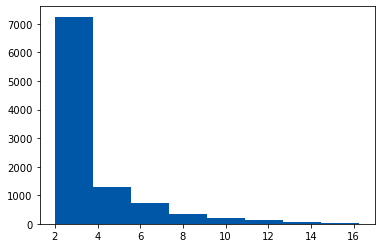

In [34]:
res_plot = plt.hist(res_all[pvs_found_all==0],bins=8)        
plt.show()

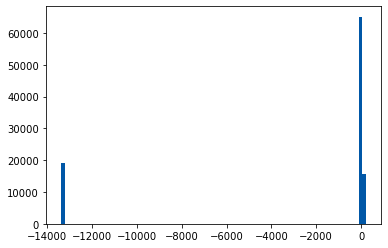

In [35]:
nTcks_plot = plt.hist(nTcks_all[pvs_found_all==1],bins=92)        
plt.show()

In [36]:
i = 0
for item in pvs_found_all:
    if item != 0 and item != 1:
        print(i, item)
    i+=1
#= plt.hist(pvs_found_all,bins=10)        
#plt.show()
print(nTcks_all[pvs_found_all==0])

[    70     17     39 ... -13365 -13365 -13365]


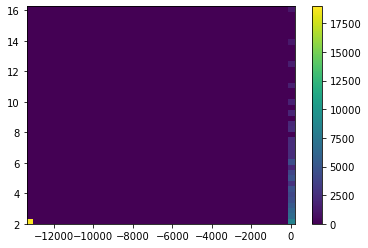

In [37]:
nTcks_res_plot = plt.hist2d(nTcks_all[pvs_found_all==1], res_all[pvs_found_all==1],bins=40)        
plt.colorbar()
plt.show()

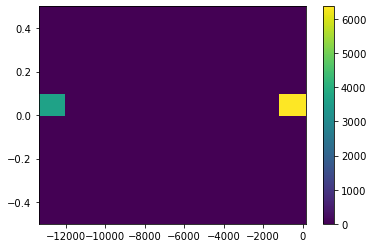

In [38]:
nTcks_res_plot = plt.hist2d(nTcks_all[pvs_found_all==0], pvs_found_all[pvs_found_all==0],bins=10)        
plt.colorbar()
plt.show()

In [39]:
i = 2

print(efficiency(labels[i], outputs[i], **eff_settings))

found_values = pv_locations(outputs[i], **eff_settings_nodiff)/10-100

valid = truth.n[i] > 4
print(valid)
zs = truth.z[i][valid]
ns = truth.n[i][valid]

print("Found nTracks Location\tDistance")
for z,n in zip(zs, ns):
    closest = np.min(np.abs(z - found_values))
    found = closest < eff_settings['difference']/10
    print(f"{found!s:5} {n:7} {z:8.5}  {closest:8.5}")
    
target_values = pv_locations(labels[i], **eff_settings_nodiff)/10-100
target_values

Found 4 of 5, added 1 (eff 80.00%)
[False  True False False  True False  True  True  True  True]
Found nTracks Location	Distance
False     104   127.89    13.291
False      36   58.404    7.2921
False      16   14.556    18.571
False      13  -35.123    31.108
False      26   52.929    12.768
True       41   114.41   0.18282


array([ -4.0246506,  65.130264 , 112.0939   , 114.622284 , 157.69952  ],
      dtype=float32)

In [40]:
for i in range(100):

    eff = efficiency(labels[i], outputs[i], **eff_settings)

    found_values = pv_locations(outputs[i], **eff_settings_nodiff)/10-100

    valid = truth.n[i] > 4
    zs = truth.z[i][valid]
    ns = truth.n[i][valid]

    total_found = 0
    for z,n in zip(zs, ns):
        closest = np.min(np.abs(z - found_values))
        found = closest < eff_settings['difference']/10
        total_found += found
        
    if total_found != eff.S:
        print(i, total_found, eff.S)

0 0 4
1 0 1
2 1 4
3 0 3
4 0 5
5 0 8
6 0 7
7 0 2
8 0 3
9 0 4
10 1 5
11 0 8
12 0 6
13 0 2
14 0 5
15 0 3
16 0 6
17 0 4
18 0 3
19 0 4
20 1 5
21 0 4
22 0 4
23 0 6
24 0 6
25 0 6
26 0 2
27 0 5
28 0 7
29 0 7
30 0 3
31 0 6
32 0 5
33 0 3
34 0 4
35 0 9
36 0 5
37 0 7
38 1 8
39 0 8
40 0 4
41 0 6
42 0 4
43 0 1
44 0 7
45 0 8
46 0 2
47 0 13
48 0 4
49 0 2
50 0 7
51 0 11
52 1 8
53 0 9
54 0 6
55 0 4
56 0 9
57 0 9
58 0 4
59 0 5
60 0 6
61 0 3
62 0 6
63 1 6
64 0 5
65 0 6
66 0 4
67 1 6
68 0 6
69 0 3
70 0 2
71 0 6
72 0 7
73 1 4
74 0 5
75 0 6
76 0 6
77 0 8
78 0 7
79 0 3
80 0 5
81 0 2
82 0 8
83 0 8
84 0 3
85 0 8
86 0 6
87 0 8
88 0 2
89 0 8
90 0 3
91 0 8
92 0 2
93 0 4
94 1 8
95 0 4
96 0 8
97 0 7
98 0 7
99 0 3


In [41]:
total_found, pvs_successful, pvs_failed = exact_efficiency(truth, outputs, **eff_settings)

In [42]:
print(pvs_failed.values())

dict_values([3199, 3016, 613, 40843, 2816, 2526, 3213, 920, 401, 1587, 1266, 706, 156, 1239, 3259, 3110, 1833, 2792, 553, 685, 713, 3113, 2097, 1144, 1894, 166, 1491, 1510, 1005, 870, 253, 447, 1129, 1965, 922, 2336, 1681, 1737, 740, 524, 140, 1428, 937, 1228, 1336, 1483, 2945, 903, 2325, 286, 317, 2612, 2148, 820, 349, 58, 2765, 1055, 207, 1201, 887, 843, 1391, 577, 573, 1375, 1325, 1220, 586, 1029, 497, 402, 336, 1108, 883, 74, 1998, 1361, 497, 661, 734, 56, 783, 262, 263, 1563, 118, 154, 469, 1077, 349, 207, 66, 260, 777, 350, 2, 398, 103, 191, 112, 419, 63, 582, 305, 429, 627, 417, 145, 32, 177, 132, 75, 10, 76, 244, 608, 231, 45, 111, 72, 49, 106, 190, 35, 20, 161, 59, 5, 69, 124, 21, 50, 20, 35, 39, 8, 18, 21, 18, 1, 30, 12, 18, 22, 11, 13, 62, 65, 30, 6, 8, 1, 8, 2, 3, 1, 10, 4, 7, 30, 1, 10, 3, 3, 6, 2, 1, 1, 2, 1, 4, 2, 4, 2, 1, 1, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1])


In [43]:
fr = (total_found - total.S) / ((total_found + total.S) / 2)
print(f'Fractional difference between the two methods: {fr:.2%}')

Fractional difference between the two methods: 200.00%


In [44]:
# Found 49507 of 54804, added 5570 (eff 90.33%) (0.557 FP/event)
print(big_total)
print(f'Found {total_found} of {big_total.real_pvs} (eff {total_found/big_total.real_pvs:.2%})')

Found 97707 of 102790, added 4907 (eff 95.05%) (0.245 FP/event)
Found 1617 of 102790 (eff 1.57%)


In [45]:
arr_successful = np.array([pvs_successful[i] for i in range(100)])
arr_failed = np.array([pvs_failed[i] for i in range(100)])

In [46]:
arr_totals = arr_successful + arr_failed
arr_totals = np.ma.array(arr_totals, mask=arr_totals==0)

arr_eff = arr_successful / arr_totals

In [47]:
print(arr_eff[5:61])
#print(arr_totals[:61])

[0.014617940199335547 0.007674144037780401 0.010574018126888218
 0.013176470588235295 0.010169491525423728 0.012102874432677761
 0.014350717535876793 0.010823220728107576 0.01644528779253637
 0.011739264751312943 0.0110803324099723 0.01718938480096502
 0.012373096446700508 0.01306970509383378 0.015514809590973202
 0.017063633131887666 0.016738030362008563 0.015664690939881456
 0.015130674002751032 0.01818181818181818 0.01865284974093264
 0.010793308148947653 0.00799543118218161 0.012010113780025285
 0.016119032858028518 0.01564537157757497 0.020367936925098553
 0.019230769230769232 0.018368846436443792 0.010455563853622106
 0.009259259259259259 0.0088 0.0137429264349232 0.0176
 0.012248468941382326 0.011235955056179775 0.01159678858162355
 0.011019283746556474 0.014018691588785047 0.01812977099236641
 0.016634050880626222 0.017057569296375266 0.012875536480686695
 0.013605442176870748 0.009513742071881607 0.013348164627363738
 0.013407821229050279 0.013237063778580024 0.014035087719298

In [48]:
np.savetxt('talks/arr_eff_sym.txt', arr_eff)
np.savetxt('talks/arr_totals_sym.txt', arr_totals)
import pickle
pickle.dumps(total)

b'\x80\x03cmodel.efficiency_res\nValueSet_res\nq\x00(K\x00K\x00K\x00K\x00tq\x01\x81q\x02.'

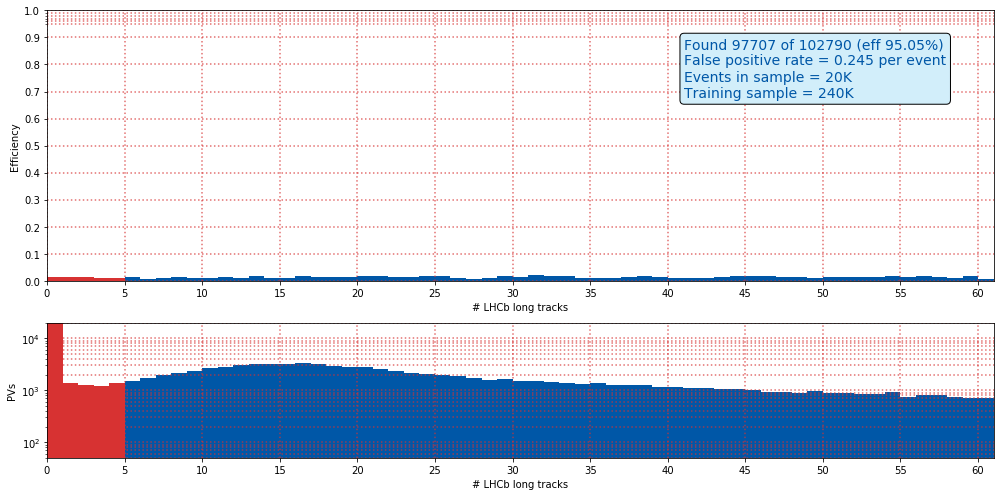

In [49]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14,7), gridspec_kw={'height_ratios':(2,1)})

ax1.bar(np.arange(5,61), arr_eff[5:61], width=1, align='edge')
ax1.bar(np.arange(5), arr_eff[:5], width=1, align='edge')
ax1.set_xlabel('# LHCb long tracks')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(0,1.0)
ax1.set_xlim(0,61)
ax1.set_yticks(np.arange(11)/10)
ax1.set_yticks([.95,.96,.97,.98,.99],minor=True)
ax1.set_xticks(np.arange(0,61,5))
ax1.grid(which='both')

ax2.bar(np.arange(5,61), arr_totals[5:61], width=1, align='edge')
ax2.bar(np.arange(5), arr_totals[:5], width=1, align='edge')
ax2.set_xlabel('# LHCb long tracks')
ax2.set_ylabel('PVs')
ax2.set_xlim(0,61)
ax2.set_ylim(50,20000)
ax2.set_yscale('log')
ax2.set_xticks(np.arange(0,61,5))
ax2.grid(which='both')

# these are matplotlib.patch.Patch properties
# total_found could be used instead of total.S
props = dict(boxstyle='round', facecolor='C2')
textprops = dict(color='C0', multialignment='left')
textstr = f'''\
Found {big_total.S} of {big_total.real_pvs} (eff {big_total.S/big_total.real_pvs:.2%})
False positive rate = {big_total.fp_rate:.3} per event
Events in sample = 20K
Training sample = 240K'''

# place a text box in upper left in axes coords
ax1.text(0.95, 0.9, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props, fontdict=textprops)

plt.tight_layout()
#plt.savefig('effntracks.pdf')
plt.show()